# importing libs and settings


In [13]:
import cv2
import numpy as np
from ultralytics import YOLO
import matplotlib.pyplot as plt
from shapely.geometry import Point, Polygon
import json
import os

video_path = 'videos/test.mp4'
output_path = 'videos/test_output.mp4'
model = YOLO('yolov8m.pt')
trespass_class_id = 0 
min_confidence = 0.5

# Intrusion Detection System  

## Polygon seting function

In [14]:
def set_polygon(video_path):
    capture = cv2.VideoCapture(video_path)
    if not capture.isOpened():
        print("Error opening video file")
        return []
    
    capture.set(cv2.CAP_PROP_POS_FRAMES, 0)
    res, frame = capture.read()
    
    if not res:
        print("Error reading the first frame")
        return []   
    
    window_text = "SET POLYGONS - PRESS ESC TO FINISH"
    cv2.namedWindow(window_text, cv2.WINDOW_NORMAL)
    try:
        cv2.setWindowProperty(window_text, cv2.WND_PROP_FULLSCREEN, cv2.WINDOW_FULLSCREEN)
    except Exception:
        pass

    display_frame = frame.copy()
    polygon_points = []

    def update_display():
        nonlocal display_frame, frame, polygon_points
        display_frame = frame.copy()

        instructions = [
            "INSTRUCTIONS:",
            "1. Click to add polygon vertices",
            "2. Press 'd' to delete last point",
            "3. Press 'c' to clear all polygon points",
            "4. Press ENTER when finished",
            "5. Press ESC to quit"
        ]

        for i, text in enumerate(instructions):
            cv2.putText(display_frame, text, (10, 30 + i*30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        if polygon_points:
            for i, (px, py) in enumerate(polygon_points):
                cv2.circle(display_frame, (px, py), 8, (0, 0, 255), -1)
                cv2.putText(display_frame, str(i+1), (px+15, py-15),
                           cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 255, 255), 2)
            if len(polygon_points) > 1:
                pts = np.array(polygon_points, dtype=np.int32)
                cv2.polylines(display_frame, [pts], True, (0, 255, 0), 2)
        
        cv2.imshow(window_text, display_frame)

    def mouse_callback(event, x, y, flags, param):
        nonlocal polygon_points
        if event == cv2.EVENT_LBUTTONDOWN:
            polygon_points.append((x, y))
            update_display()
    
    cv2.setMouseCallback(window_text, mouse_callback)

    update_display()
    
    while True:
        key = cv2.waitKey(0) & 0xFF
        
        if key == 13 or key == 10:  # ENTER to finish
            if len(polygon_points) >= 3:
                break
            else:
                print("Need at least 3 points for a polygon")
        elif key == ord('d'):  # Delete last point
            if polygon_points:
                polygon_points.pop()
                update_display()
        elif key == ord('c'):  # Clear
            polygon_points = []
            update_display()
        elif key == 27:  # ESC 
            polygon_points = []
            break
    
    capture.release()
    cv2.destroyAllWindows()
    return polygon_points

In [15]:
print("Polygon points setting...")
polygon_points = set_polygon(video_path)

if not polygon_points:
    print("Polygon setting cancelled or no points defined.")
    exit()

print(f"Polygon setted with {len(polygon_points)} points:")
print(polygon_points)

shape_polygon = Polygon(polygon_points)

def save_polygon(points, filename='restricted_zones.json'):
    if not points:
        print("No points to save.")
        return  
    coordinates = {"restricted_zone": points}
    with open(filename, 'w') as f:
        json.dump(coordinates, f, indent=4)
    print(f"Polygon coordinates saved to {filename}")

save_polygon(polygon_points)


Polygon points setting...
Polygon setted with 4 points:
[(922, 443), (958, 718), (1113, 719), (1116, 468)]
Polygon coordinates saved to restricted_zones.json


## Plot

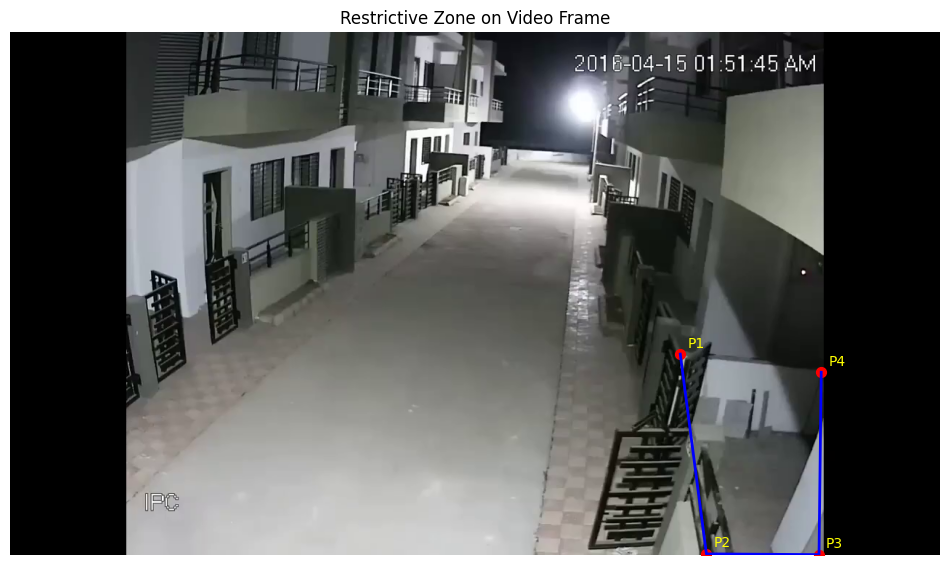

In [16]:

capture = cv2.VideoCapture(video_path)
capture.set(cv2.CAP_PROP_POS_FRAMES, 30)  
ret, frame = capture.read()
capture.release()

frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(frame_rgb)

x_coords = [point[0] for point in polygon_points]
y_coords = [point[1] for point in polygon_points]

plt.scatter(x_coords, y_coords, c='red', s=50, marker='o')

plt.plot(x_coords, y_coords, c='blue', linestyle='-', linewidth=2)

for i, (x, y) in enumerate(polygon_points):
    plt.annotate(f'P{i+1}', (x, y), xytext=(5, 5), 
                textcoords='offset points', color='yellow')

plt.title('Restrictive Zone on Video Frame')
plt.axis('off')  
plt.show()

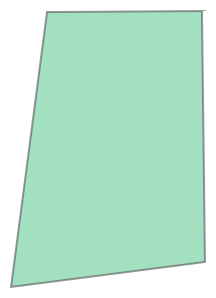

In [17]:
shape_polygon

## Itrusuion func

In [18]:
def process_video():
    capture = cv2.VideoCapture(video_path)
    if not capture.isOpened():
        print("Error opening video file")
        return
    
    width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = capture.get(cv2.CAP_PROP_FPS)
    frame_count = int(capture.get(cv2.CAP_PROP_FRAME_COUNT))
    
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))
    
    frame_num = 0
    trespass_detected = False
    
    while capture.isOpened():
        success, frame = capture.read()
        if not success:
            break
            
        frame_num += 1
        print(f"Processing frame {frame_num}/{frame_count}", end='\r')
        
        cv2.polylines(frame, [np.array(polygon_points)], True, (0, 0, 255), 2)
        cv2.putText(frame, "Restricted Area", 
                   (polygon_points[0][0], polygon_points[0][1]-10), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
        
        results = model(frame, verbose=False, classes=[trespass_class_id])[0]
        
        current_trespass = False
        
        for box in results.boxes:
            conf = float(box.conf)
            if conf < min_confidence:
                continue
                
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            
            feet_x = (x1 + x2) // 2
            feet_y = y2
            
            point = Point(feet_x, feet_y)
            if shape_polygon.contains(point):
                current_trespass = True
                trespass_detected = True
                
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 2)
                cv2.putText(frame, f'Trespasser: {conf:.2f}', (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
                
                cv2.circle(frame, (feet_x, feet_y), 8, (0, 0, 255), -1)
            
            else:
                
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, f'Person: {conf:.2f}', (x1, y1-10),
                           cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
                
                cv2.circle(frame, (feet_x, feet_y), 8, (0, 255, 0), -1) 
        
        if current_trespass:
            cv2.putText(frame, "ALARM!", (width//6, 50),
                       cv2.FONT_HERSHEY_SIMPLEX, 1.5, (0, 0, 255), 3)
        
        out.write(frame)
    
    capture.release()
    out.release()
    
    if trespass_detected:
        print("\nTrespassing detected in video!")
    else:
        print("\nNo trespassing detected")
    print(f"Output saved to: {output_path}")

In [19]:
process_video()

Processing frame 3711/3711
Trespassing detected in video!
Output saved to: videos/test_output.mp4
